In [ ]:
%%bash
pip install --no-cache-dir -qU pip wheel
pip install --no-cache-dir -qU numpy pandas matplotlib seaborn scikit-learn
pip install --no-cache-dir -qU tensorflow-gpu
pip check

# Batch normalisation layers

In this reading we will look at incorporating batch normalisation into our models and look at an example of how we do this in practice.

As usual, let's first import tensorflow.

In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.get_logger().setLevel('ERROR')

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

We will be working with the diabetes dataset that we have been using in this week's screencasts.

Let's load and pre-process the dataset.

In [3]:
# Load the dataset
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [4]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [5]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0)) / targets.std()

In [6]:
# Split the dataset into training and test datasets
train_data, test_data, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.1)
print(f"Train data shape: {train_data.shape}")

Train data shape: (397, 10)


### Batch normalisation - defining the model

We can implement batch normalisation into our model by adding it in the same way as any other layer.

In [8]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', 
        input_shape=(train_data.shape[1],)),
    # <- Batch normalisation layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    # <- Batch normalisation layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=256, activation='relu')
])
# NB: We have not added the output layer because 
# we still have more layers to add!

Recall that there are some parameters and hyperparameters associated with batch normalisation.

* The hyperparameter **momentum** is the weighting given to the previous running mean when re-computing it with an extra minibatch. By **default**, it is set to 0.99.

* The hyperparameter **$\epsilon$** is used for numeric stability when performing the normalisation over the minibatch. By **default** it is set to 0.001.

* The parameters **$\beta$** and **$\gamma$** are used to implement an affine transformation after normalisation. By **default**, $\beta$ is an all-zeros vector, and $\gamma$ is an all-ones vector.

### Customising parameters
These can all be changed (along with various other properties) by adding optional arguments to `tf.keras.layers.BatchNormalization()`.

We can also specify the axis for batch normalisation. By default, it is set as -1.

Let's see an example.

In [9]:
# Add a customised batch normalisation layer
model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, epsilon=0.005, axis=-1,
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05),
    gamma_initializer=tf.keras.initializers.Constant(value=0.9)
))

In [10]:
# Add the output layer
model.add(tf.keras.layers.Dense(units=1))

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                704       
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 256)              

## Compile and fit the model

Let's now compile and fit our model with batch normalisation, and track the progress on training and validation sets.

First we compile our model.

In [11]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

print(model.loss)
print(model.optimizer)
print(model.metrics)

[]


Now we fit the model to the data.

In [ ]:
# Train the model
history = model.fit(train_data, train_targets,
    validation_data=(test_data, test_targets),
    epochs=100, batch_size=64, verbose=0)

Finally, we plot training and validation loss and accuracy to observe how the accuracy of our model improves over time.

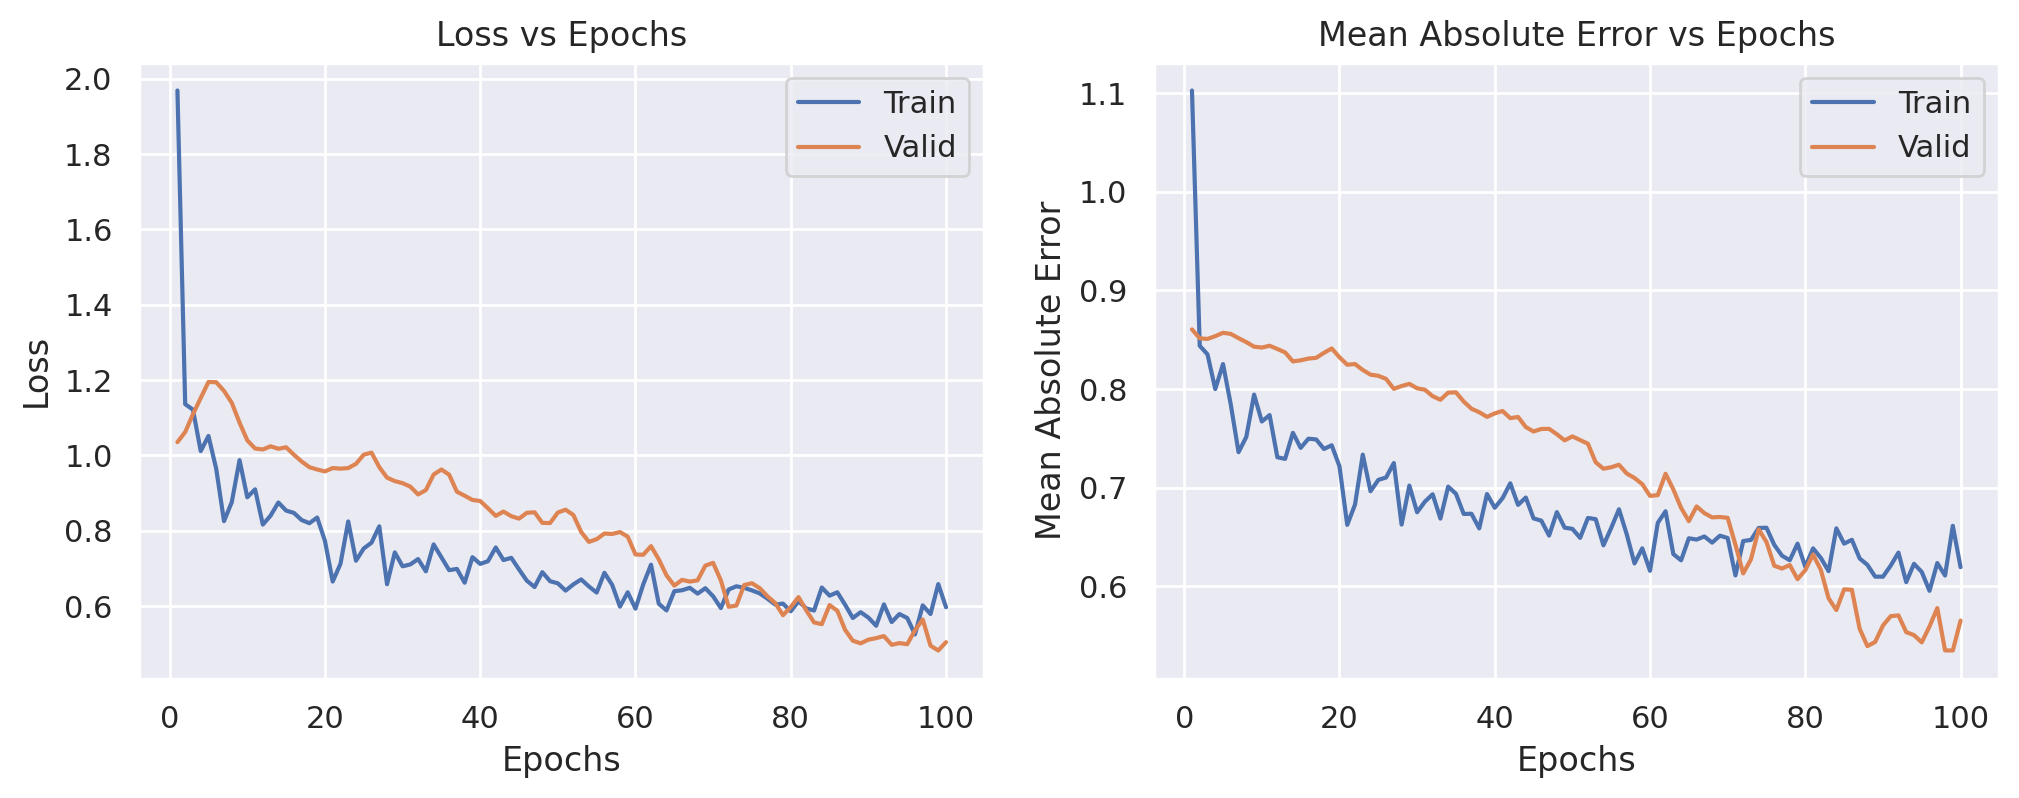

In [15]:
# Plot the learning curves
frame = pd.DataFrame(history.history)
epochs = np.arange(1, len(frame)+1)

fig = plt.figure(figsize=(12, 4))

# Loss plot
ax = fig.add_subplot(121)
ax.plot(epochs, frame['loss'], label='Train')
ax.plot(epochs, frame['val_loss'], label='Valid')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Epochs')
ax.legend()

# Accuracy plot
ax = fig.add_subplot(122)
ax.plot(epochs, frame['mean_absolute_error'], label='Train')
ax.plot(epochs, frame['val_mean_absolute_error'], label='Valid')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Mean Absolute Error vs Epochs')
ax.legend()
plt.show()

## Further reading and resources
* https://keras.io/layers/normalization/
* https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/BatchNormalization